<a href="https://colab.research.google.com/github/stemgene/fastai2019/blob/master/Lesson1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1 - What's your pet
Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File->Open` now and click 00_notebook_tutorial.ipynb.

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [0]:
#Reload all modules before executing a new line. If a module is edited, it is not necessary to rerun the import commands, the modules will be reloaded automatically.
%reload_ext autoreload
%autoreload 2
# This command ensures that all matplotlib plots will be plotted in the output cell within the notebook and will be kept in the notebook when saved
%matplotlib inline 

We import all the necessary packages. We are going to work with the [fastai V1 library](https://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller batch size (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these **37** distinct categories. According to their paper, the best accuracy they could get in 2012 was **59.21%**, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [5]:
help(untar_data)  # download data automatically

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [6]:
path = untar_data(URLs.PETS)
path # since you've already untar this, the second time run path again, it won't download it again.

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [7]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
# use '/' to create some paths. '/' is a function in Python3.0
path_anno = path/'annotations'
path_img = path/'images' # a path through the images in the dataset

The first thing we do when we approach a problem is to take a look at the data. We always need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves, concretely, `dictionary/label_index.jpg`. We will need to extract them to be able to classify the images into the correct categories. 

In [9]:
fnames = get_image_files(path_img)
fnames[:5]
# file's name is also the label.

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_161.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_165.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_86.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Siamese_247.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_7.jpg')]

Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html). This object represents all of the data you need to build a model and try to make it really easy to create that ImageDataBunch, which contains training set and validation set with images and labels.

In this case, we need to extract the labels from names, we use `from_name_re`, `re` is the module in Python does regular expressions.


In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

* path_img: dictionary path of images
* fnames: list of file's name
* pat: pattern of re
* ds_tfm: transform
* size: same size 224. GPUs need to apply the exact same instruction through a whole bunch of things at the same time in order to be fast. If the size is not 224 * 224, use transference, can make size to 224

ImageDataBuch.from_name_re will return a DabaBunch object, in fastai, everything the model with is gonna be a data of bunch of object.
The data bunch of object contains 2 - 3 datasets, and for each of those it contains images or texts and labels 
or your tabular data in your labels or so. And they will put into one place (i.g. data)



In [11]:
# 224 is good for most of the time. the last layer is 7*7, so we want the input is the times of 7*2
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224) 
data.normalize(imagenet_stats) # normalization: same mean and sd

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Abyssinian,wheaten_terrier,great_pyrenees,pomeranian,yorkshire_terrier
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pomeranian,american_bulldog,Bombay,scottish_terrier,Abyssinian
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

**Normalize an image**: The pixel value starts from 0-255, and 3 channels (red, green, blue). Some channels might tend to be bright and some might dark. It really helps train a deep learning model if each one of those red, green and blue channels has a mean of 0 and a sd of 1.

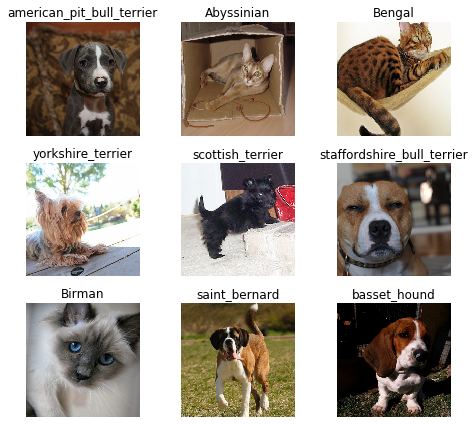

In [12]:
data.show_batch(rows=3, figsize=(7,6))

In [13]:
print(data.classes)
len(data.classes), data.c
# data.c is the number of class in classification problems.

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use **a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier**. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building *a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs)*.

* DataBunch: general concept in fastai. From data bunch there are some classes for particular applications like image data bunch
* Learner: general concept in fastai. can learn to fit the model and found that there are various sub classes to make things easier. In this case, we use `cnn_learner` to complement convolutional neural network.
* resnet: always useful, need to choose the size of the network, resnet34 or resnet50. The smaller one will run faster. When first time to use it, it will download the resnet34 pretrained weights (https://download.pytorch.org/models/resnet34-333f7ec4.pth"). 我第一次在一个新安装的环境里运行这些代码，它会下载ResNet34预训练权重。也就是说，这是一个针对特定任务训练过的特定模型。这个任务是训练模型看50万张各种物品的图片，这些物品属于1000个种类，这个图片数据集叫ImageNet。所以我们可以下载这些预训练过的参数，不必从一个一无所知的模型，而是从一个已经能够识别ImageNet里1000种类别物品的模型开始。并非所有37种品种都在ImageNet里，但里面确实有几种猫和几种狗。所以这个预训练模型知道一些猫和狗长什么样子，并且知道很多动物长什么样子，认识很多照片。所以我们是从一个空模型开始，而是基于一个已经懂得识别一些图片的模型。预训练模型会在第一次被使用时被自动下载，以后就不会再下载了，而是直接使用先前下载的那个。

#### Transfer learning: take a model that already knows how to do something pretty well and make it so that it can do your thing really well.

这部分很重要。我们将学习很多有关迁移学习的内容。这是整个课程的重点。迁移学习研究的是怎样使用一个已经能很好地完成一些任务的模型来完成新的任务。我们使用一个预训练的模型，然后调整它，不再使用ImageNet数据来预测一千种分类，而是使用宠物数据集来预测 37 种品种。这样的话，相对于一次常规的训练，你训练一个模型仅需百分之一的时间和数据，甚至更少。有可能会少于千分之一。记得我在展示的Nikhil的去年第一课项目的幻灯片吗，他只用了30张图片。ImageNet里没有板球和篮球的图片，但结果ImageNet还是很擅长识别世界里的各种事物，仅仅30个打篮球和板球的例子就足够构建一个几乎完美的分类器 

In [14]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 77.8MB/s]


In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

我们可以开始拟合它。你可以使用一个叫fit的方法。但实践中，你应该总是使用fit_one_cycle这个方法。简单来讲，one cycle learning 是4月份发表的 一篇论文 ，它明显比以前的方法更快更准确。再重复一遍，我不想教大家怎样用2017年的方法做深度学习。在2018年，最好的拟合模型的方法是使用one cycle。

We will train for 4 epochs (4 cycles through all our data).

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.371007,0.299686,0.101489,26:43
1,0.617979,0.261212,0.081191,24:44
2,0.388022,0.228258,0.073072,23:45
3,0.283109,0.215216,0.066306,26:17


We train this model use 4 epoches, it ran quickly. The reason is that little thicky. The CNN has many layers, what we do was added a few extra layers to the end that we only trained those, we basically left most of the models exactly as it was. So that's really fast. And it'll basically never overfit.

We got the trained model, actually, the training process just create a bunch of weights.

Use `learn.save` to save weights in a subdirectory in the same place where data came from.

In [0]:
learn.save('stage-1')

## Results

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly.

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

使用这个分类任务解释类（`ClassificationInterpretation`）。我们使用`from_learner`这个方法，我们传入一个learn对象。一个learn对象包含了两部分信息：
1. 数据是什么
2. 模型是什么。现在它不仅是一个结构，它已经是一个训练完成的模型

这是用来解释这个模型所需要的所有信息。

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

True

### plot_top_losses

我们调用一下`plot_top_losses`，这大概是一个最有用的方法。损失函数是用来评价你的预测的效果。比如说，你为一个猫的图片预测了一个类别，并且非常确信，但事实上你又预测错了，这时就会有一个比较高的损失，因为你对错误答案很确信。这就是损失值比较高的含义。通过画出最高的损失值，我们就可以看到我们最严重的错误是什么，或者对哪个错误答案最确信。

Show images in top_losses along with their **prediction, actual, loss, and probability of predicted class实际值的概率** in a multilabeled dataset.

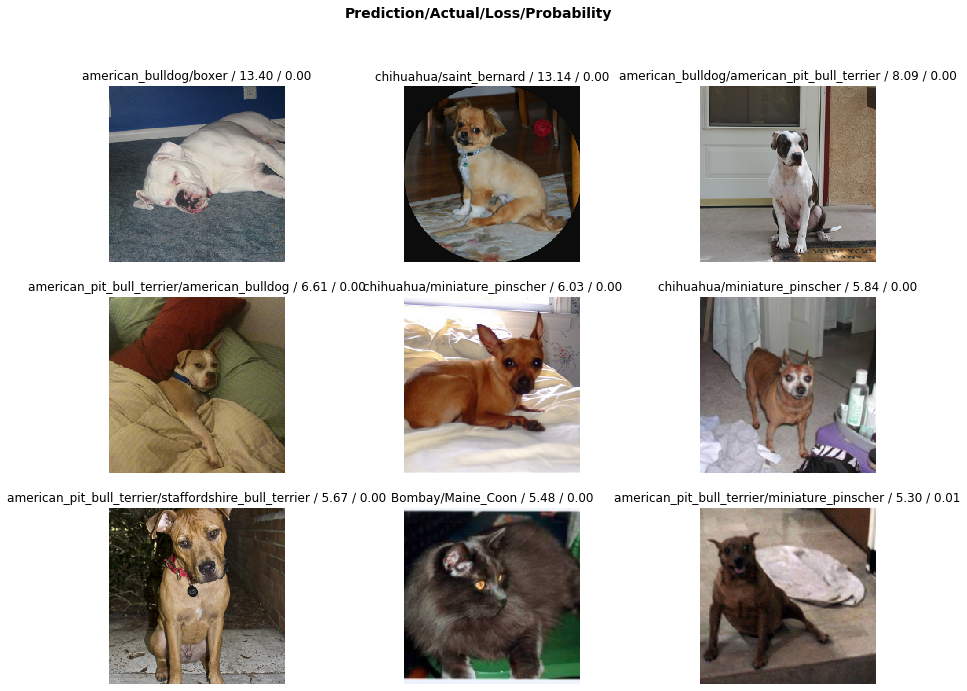

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

In [19]:
doc(interp.plot_top_losses)

#### 混淆矩阵

另外一个有用的工具是混淆矩阵，它显示了每个品种被预测成各个品种的次数。在这个例子中，因为模型预测得很准确，对角线显示了结果很好。

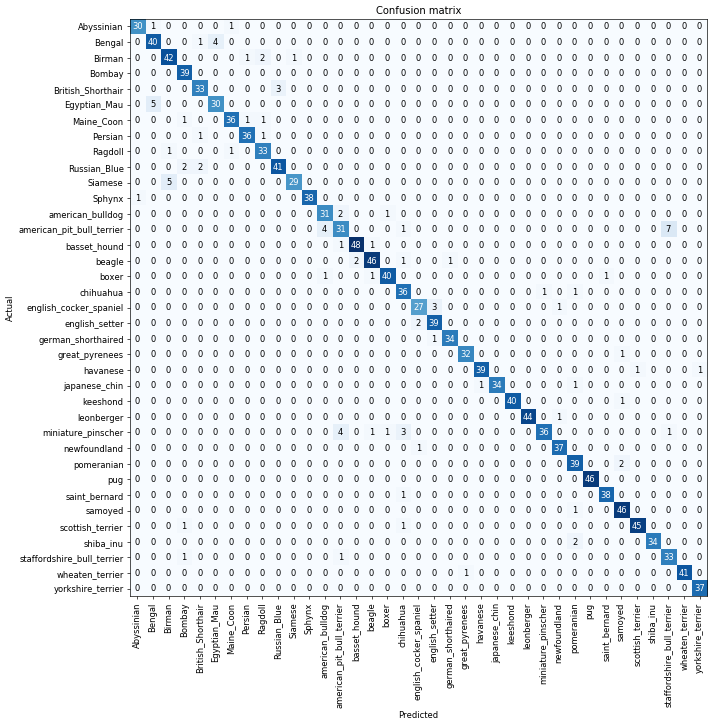

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### most_confused

在类别比较多时，不要使用混淆矩阵。你可以调用“most_confused”。会抓出混淆矩阵里被预测错次数最多的类别组合

In [21]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('Egyptian_Mau', 'Bengal', 5),
 ('Siamese', 'Birman', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('american_pit_bull_terrier', 'american_bulldog', 4),
 ('miniature_pinscher', 'american_pit_bull_terrier', 4),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('Birman', 'Ragdoll', 2),
 ('Russian_Blue', 'Bombay', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('beagle', 'basset_hound', 2),
 ('english_setter', 'english_cocker_spaniel', 2),
 ('pomeranian', 'samoyed', 2),
 ('shiba_inu', 'pomeranian', 2)]

## Unfreezing, fine-tuning, and learning rate

Since our model is working as we expect it to, we will unfreeze our model and train some more.

If we try to build a whole model回过头来训练整个模型。这是为什么我们经常使用这个两阶段过程。首先，我们调用ConvLearner的 `fit` 或者 `fit_one_cycle` 方法，它只会微调我们加在末尾的一些层，这一步训练得很快，也不会过拟合。为了得到更好地模型，你需要调用 `unfreeze`。 `unfreeze` 让它训练整个模型，然后我们再调用一遍`fit_one_cycle`。

In [22]:
learn.unfreeze()  # train the whole model.
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.707626,0.384875,0.117727,35:29


**Understand the layers of CNN**: [可视化卷积神经网络的层,](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf) 
* 第一层的真实系数的9个例子。它们检查相互邻近的一组像素。第一个认出了有对角线的一组像素，第二个认出了一个反方向的对角线，第三个认出了从黄色到蓝色的渐变，等等。这是些很小很简单的过滤器（filters）。这是ImageNet预训练卷积神经网络的第一层, 发现了一些非常简单的斜线和直线
* 第二层使用这些过滤器的结果来做运算。它学会创建了一些能找出类似位于左上方的角的东西。有些学会了找出右侧的曲线或者小圆圈等等。在第一层里，它们只能认出到一条线。在第二层里，它们可以认出由两条线构成的图形或者重复的几条线,找到了很简单的形状
* 第三层可以找到它们的组合,第三层能识别所有第二层识别的东西和第二层里东西的组合。
* 第四层能识别所有第三层识别的东西和它们的组合。在第四层里，它们可以认出狗脸或者鸟腿。
* 第五层，它们可以认出鸟眼和蜥蜴，或者一些品种的狗的脸。这样你可以看到一步步的到第34层，可以认出特定的猫狗的品种。这就是它的工作原理。

We don't want to change the first layer, it is so basic. Whereas we want to change the last layer, the face of a dog's face. This intuition is understanding that the different layers of a neural network represnets different levels of kind of semantic complexity.

这就是我们对这个模型的微调没有作用的原因，默认情况下，它以相同的速度训练所有层，就是说它用相同的方式更新代表对角线和渐变的参数和代表眼睛样子这种具体细节的参数。

改变它之前，我们先把它恢复成原来的样子。

In [23]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Abyssinian,wheaten_terrier,great_pyrenees,pomeranian,yorkshire_terrier
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pomeranian,american_bulldog,Bombay,scottish_terrier,Abyssinian
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel

#### Learning rate finder

In [24]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


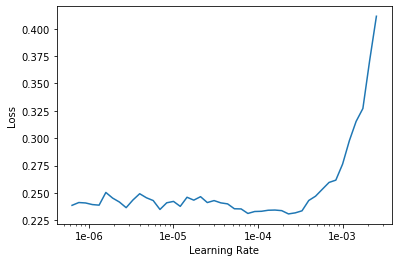

In [25]:
learn.recorder.plot()

这会画出learning rate finder的结果，这里展示的是最重要的参数——学习率。学习率代表更新模型参数的速度。x轴代表学习率，学习率逐渐增加。y轴代表损失度。你可以看到，学习率超过10^-4后，损失度变差了。这和实际发生的一样。我们可以验证它，按下 `shift`+`tab` ，学习率默认是0.003，你可以看到损失度变差了。我们想做些微调，不能使用这么高的学习率。按照学习率探测器的结果，我试着选择1e-6。但是不能用这个来训练所有的层，后面的几层在我们加快速度前也运行得很好。所以我们传入一个学习率的区间到 `learn.fit_one_cycle`。我们这样做：

In [26]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.243325,0.215111,0.067659,35:37
1,0.211953,0.201420,0.063599,36:03


使用Python里的 slice关键字，它接收一个起始值和结束值。这样会按照1e-6的学习率训练第一层，按照1e-4的学习率训练最后一层(make the second part of that slice ten times smaller than the first stage)，按照层数等分，每层使用对应的学习率。

## Training: resnet50

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=299, bs=bs//2).normalize(imagenet_stats)

In [29]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 49.0MB/s]


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


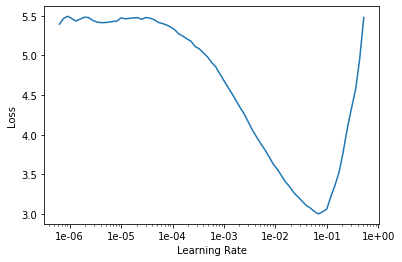

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(2)  #8

epoch,train_loss,valid_loss,error_rate,time
0,0.683020,0.318114,0.094046,1:34:35


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

## Other data formats

In [32]:
path = untar_data(URLs.MNIST_SAMPLE)
path

PosixPath('/root/.fastai/data/mnist_sample')

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

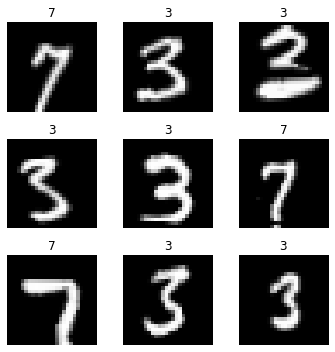

In [34]:
data.show_batch(rows=3, figsize=(5,5))

In [35]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 76.6MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.202086,0.094830,0.962709,01:05
1,0.124707,0.055320,0.980373,01:06


In [36]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

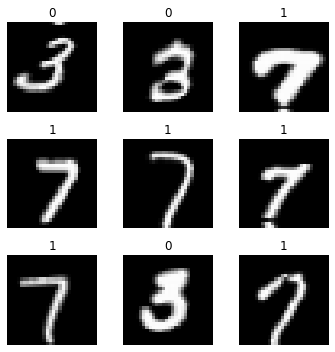

In [38]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [39]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [40]:
fn_paths = [path/name for name in df['name']]
fn_paths[:2]

[PosixPath('/root/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/21102.png')]

In [41]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [42]:

data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [43]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [44]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']